In [1]:
#imports
import random
import matplotlib.pyplot as plt
import numpy as np

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]
plt.rcParams.update({'font.size': 8})

try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

installing cirq...
installed cirq.


## 2. Phase Flip Code

This section covers a 3-qubit phase flip error correcting code.

Initialize a circuit with 3 qubits and 1 classical bit.

Entangle the state of  q0  with the other qubits.

Put all qubits in equal superpositions to correct  |+⟩  and  |−⟩  states from switching instead of  |0⟩  and  |1⟩ .

In [2]:
qubits = cirq.NamedQubit.range( 3, prefix = "q")
encode_circuit = cirq.Circuit()
encode_circuit.append(cirq.CNOT(qubits[0],qubits[1]))
encode_circuit.append(cirq.CNOT(qubits[0],qubits[2]))
encode_circuit.append(cirq.H.on_each(qubits))
encode_circuit

┌──┐
q0: ───@────@─────H───
       │    │
q1: ───X────┼H────────
            │
q2: ────────X─────H───
           └──┘

Simulate a phase flip error on q0 - flips a qubit from |+⟩ to  |−⟩

In [3]:
noisy_channel_circuit = cirq.Circuit()

noisy_channel_circuit.append(cirq.Z(qubits[0]))
noisy_channel_circuit

q0: ───Z───

Error Detection: Next, we will detect if there's been an error by checking the phase (do the phases agree with each other or are they diffent?) of  q0  with the other qubits by bringing all the qubits out of superposition (H gates) and then checking the parity of the  q0  with the ancilla qubits by applying two CNOTs controlled by  q0  and targeting the ancilla qubits.

In [4]:
detection_circuit = cirq.Circuit()

detection_circuit.append(cirq.H.on_each(qubits))
detection_circuit.append(cirq.CNOT(qubits[0], qubits[1]))
detection_circuit.append(cirq.CNOT(qubits[0], qubits[2]))
detection_circuit

q0: ───H───@───@───
           │   │
q1: ───H───X───┼───
               │
q2: ───H───────X───

Error Correction:

We will now create a circuit to update  q0  if both  q1  and  q2  have detected a bit flip so that  q0  stores the correct logical state. Specifically, apply the Toffoli (CCX) gate controlled by  q2  and  q1 , targeting  q0 .

In [5]:
correction_circuit = cirq.Circuit()

correction_circuit.append(cirq.CCNOT(qubits[2], qubits[1],qubits[0]))
correction_circuit

q0: ───X───
       │
q1: ───@───
       │
q2: ───@───

Decoding: Lastly, the logical state has been stored in  q0 , so we will create a decoding circuit to measure this qubit in order to decode the final logical state.

In [6]:
decode_circuit = cirq.Circuit()

decode_circuit.append(cirq.measure(qubits[0]))

decode_circuit

q0: ───M───

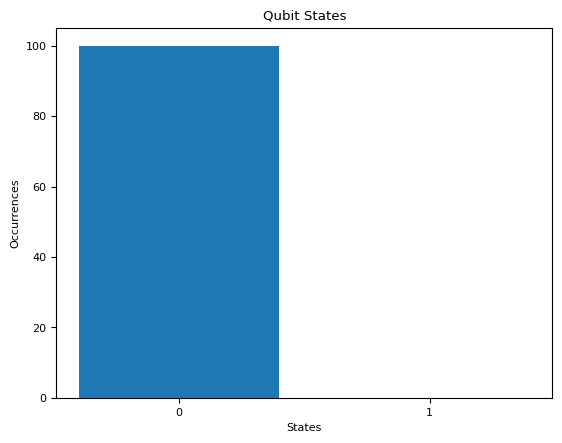

In [7]:
phaseflip_circuit = encode_circuit + noisy_channel_circuit + detection_circuit + correction_circuit + decode_circuit
phaseflip_circuit
sim = cirq.Simulator()

result = sim.run(phaseflip_circuit, repetitions = 100)


hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences', tick_label=binary_labels(1))

plt.show()

In [8]:
print(phaseflip_circuit)

           ┌──┐
q0: ───@────@─────H───Z───H───@───@───X───M───
       │    │                 │   │   │
q1: ───X────┼H────────────H───X───┼───@───────
            │                     │   │
q2: ────────X─────H───────H───────X───@───────
           └──┘


If we decide to put our logical qubit in the |+> state, instead of the |0> state, we can see an interesting problem occur.

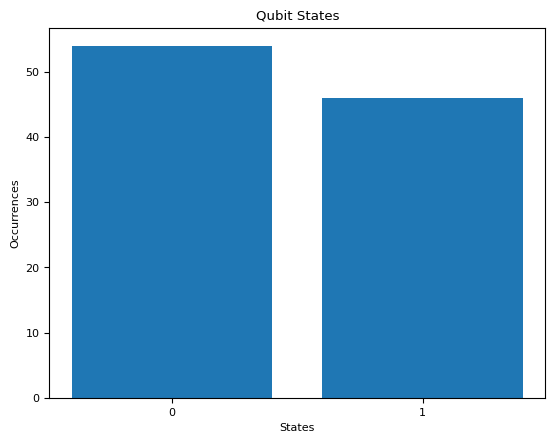

In [9]:
# PREPARATION
prepare_circuit = cirq.Circuit()
prepare_circuit.append(cirq.H(qubits[0]))

# SIMULATING
phaseflip_circuit = prepare_circuit + encode_circuit + noisy_channel_circuit + detection_circuit + correction_circuit + decode_circuit

sim = cirq.Simulator()
result = sim.run(phaseflip_circuit, repetitions = 100)

hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences', tick_label=binary_labels(1))

plt.show()

It is hard to tell if this is |+⟩ or if an error incurred and it is now  |−⟩  or even a different superposition.

To make sure the error has been corrected for this case, we can apply an H-Gate to q0 right before encoding to rotate it's state into the computational basis, so that we can be sure if the error has been corrected.

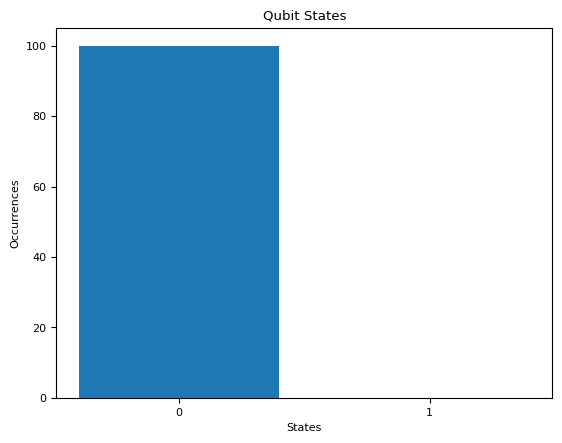

In [10]:
# PREPARATION
prepare_circuit = cirq.Circuit()
prepare_circuit.append(cirq.H(qubits[0]))


# SIMULATING
phaseflip_circuit = prepare_circuit + encode_circuit + noisy_channel_circuit + detection_circuit + correction_circuit + cirq.H(qubits[0]) + decode_circuit

sim = cirq.Simulator()
result = sim.run(phaseflip_circuit, repetitions = 100)

hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences', tick_label=binary_labels(1))

plt.show()

To Do: Expand this 3 qubit error correcting code to a 4+ qubit error correcting code. Can these sustain more errors than the one above? Are there patterns to how many errors an n qubit code can handle?